In [1]:
import pandas as pd
from IPython.display import Image, display
import base64

api_key = '6669d7a6eb70f4.27564131'

# be careful with stocks like TSLA doesn't have dividends and will still a top 5 market cap spot, without generating any data
#tickers = ['NESN.SW', 'UL.US', 'MDLZ.US', 'CMG.US', 'KHC.US', 'GIS.US', 'HSY.US', 'SYY.US', 'KHC.US']  
#tickers = ['MSFT.US','AAPL.US','AMZN.US','CB.US','INTC.US','AMD.US'] 
tickers = ['BAC.US']  

# Top 10 S&P 500, excluding BRK-B.US which doesn't pay dividends 
# AAPL.US,MSFT.US,NVDA.US,AMZN.US,META.US,GOOGL.US,GOOG.US,LLY.US,JPM.US
tickers = ['AAPL.US','MSFT.US','NVDA.US','AMZN.US','META.US','GOOGL.US','GOOG.US','LLY.US','JPM.US']

# top S&P500 companies that have paid dividends since at least 2023
# (BRBK, AMZN,TSLA don't pay dividends, and GOOG, GOOL, NVDA, META only just started)
# AAPL.US,MSFT.US,LLY.US,JPM.US,AVGO.US,UNH.US,V.US,PG.US,JNJ.US,NVDA.US,AMZN.US,GOOG.US,GOOGL.US,META.US
tickers = ['NVDA.US','AAPL.US','MSFT.US','LLY.US','JPM.US','AVGO.US','UNH.US','V.US','PG.US','JNJ.US','AMZN.US','GOOG.US','GOOGL.US','META.US']

# Constants for the number of days before earnings and after dividend
days_after_dividend = 0  # Number of days after the dividend to buy
days_before_earnings = 0  # Number of days before earnings to sell

# Define the period of analysis
start_date = '2019-09-09'
end_date = '2024-09-09'

# Initial nominal investment in each stock
initial_investment = 1000

import download_info as di

downloaded_data,market_caps = di.download_data(api_key, tickers, start_date, end_date)



Fetching data for NVDA.US...
<Response [200]>   https://eodhd.com/api/eod/NVDA.US?from=2019-09-09&to=2024-09-09&api_token=6669d7a6eb70f4.27564131&fmt=json
<Response [200]>   https://eodhd.com/api/calendar/earnings?api_token=6669d7a6eb70f4.27564131&from=2019-09-09&to=2024-09-09&symbols=NVDA.US
Earnings Dates for NVDA.US: 2019-11-14, 2020-02-13, 2020-05-21, 2020-08-19, 2020-11-18, 2021-02-24, 2021-05-26, 2021-08-18, 2021-11-17, 2022-02-16, 2022-05-25, 2022-08-24, 2022-11-16, 2023-02-22, 2023-05-24, 2023-08-23, 2023-11-21, 2024-02-21, 2024-05-22, 2024-08-28
<Response [200]>   https://eodhd.com/api/div/NVDA.US?from=2019-09-09&to=2024-09-09&api_token=6669d7a6eb70f4.27564131&fmt=json
Dividend Dates for NVDA.US: 2019-11-27, 2020-02-27, 2020-06-04, 2020-09-01, 2020-12-03, 2021-03-09, 2021-06-09, 2021-08-31, 2021-12-01, 2022-03-02, 2022-06-08, 2022-09-07, 2022-11-30, 2023-03-07, 2023-06-07, 2023-09-06, 2023-12-05, 2024-03-05, 2024-06-11

Fetching data for AAPL.US...
<Response [200]>   https://

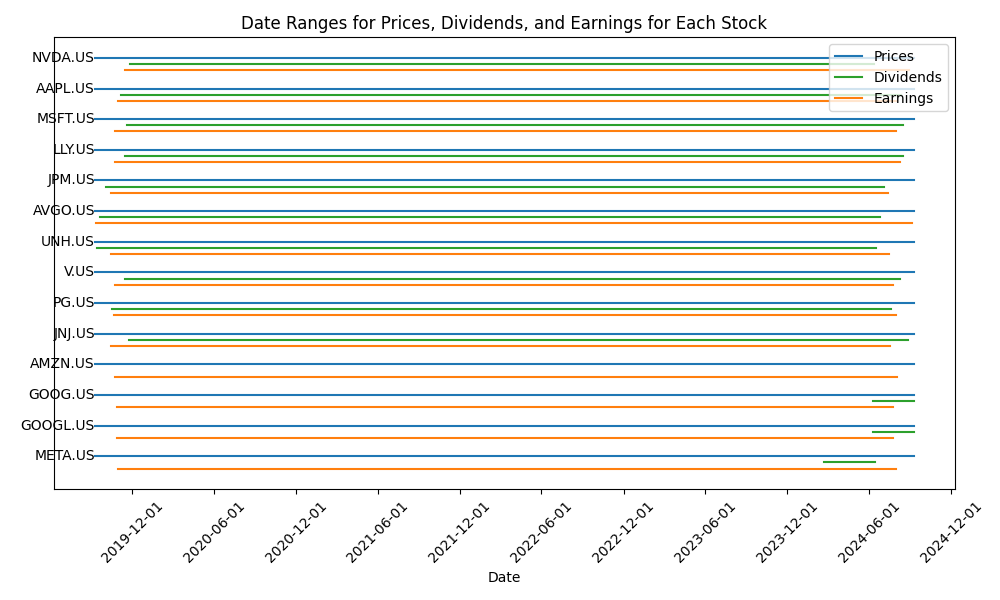

In [8]:
import chart_available_dates as cad
base64_image = cad.plot_stock_date_ranges(downloaded_data)
display(Image(data=base64.b64decode(base64_image), format='png'))

In [3]:
import food_stock_strategy_simulation as fss
top_stocks_by_date = fss.create_top_stocks_by_date(market_caps, start_date, end_date, 5)

No data for NVDA.US on or before 2019-09-09 00:00:00
No data for MSFT.US on or before 2019-09-09 00:00:00
No data for LLY.US on or before 2019-09-09 00:00:00
No data for JPM.US on or before 2019-09-09 00:00:00
No data for AVGO.US on or before 2019-09-09 00:00:00
No data for UNH.US on or before 2019-09-09 00:00:00
No data for V.US on or before 2019-09-09 00:00:00
No data for PG.US on or before 2019-09-09 00:00:00
No data for JNJ.US on or before 2019-09-09 00:00:00
No data for AMZN.US on or before 2019-09-09 00:00:00
No data for GOOG.US on or before 2019-09-09 00:00:00
No data for GOOGL.US on or before 2019-09-09 00:00:00
No data for META.US on or before 2019-09-09 00:00:00
No data for NVDA.US on or before 2019-09-10 00:00:00
No data for MSFT.US on or before 2019-09-10 00:00:00
No data for LLY.US on or before 2019-09-10 00:00:00
No data for JPM.US on or before 2019-09-10 00:00:00
No data for AVGO.US on or before 2019-09-10 00:00:00
No data for UNH.US on or before 2019-09-10 00:00:00
No d

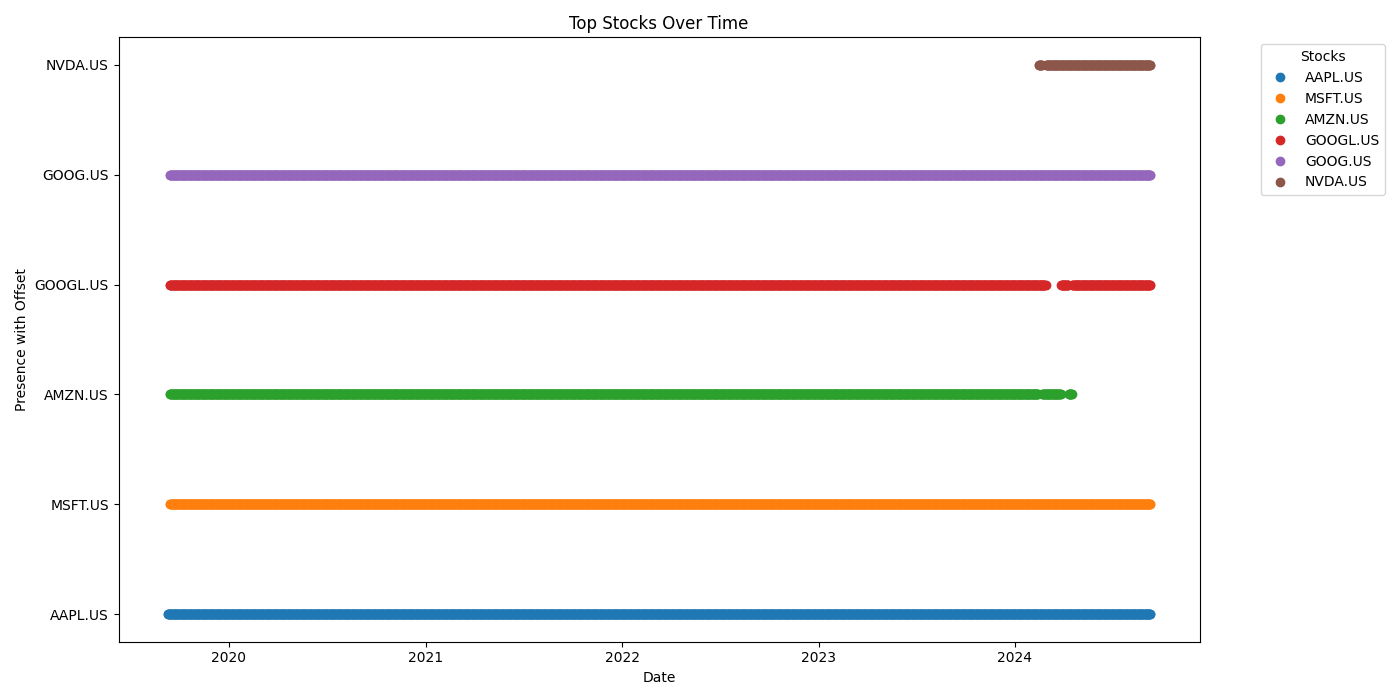

In [4]:
import chart_top_stocks as cts
plot_top_stocks_base64 = cts.chart_top_stocks(top_stocks_by_date)
display(Image(data=base64.b64decode(plot_top_stocks_base64), format='png'))

In [5]:
import food_stock_strategy_simulation as fss
investment_results = fss.process(downloaded_data, top_stocks_by_date, days_after_dividend, days_before_earnings, initial_investment)

Bought: AAPL.US, Pool: 0, Date: 2019-11-07, Investment: $1000.00
No free capital for MSFT.US on 2019-11-20
Bought: MSFT.US, Pool: 1, Date: 2019-11-20, Investment: $1000.00
Sold: MSFT.US, Pool: 0, Date: 2020-01-28, Gain: $224.57, Total Return: $1224.57
Sold: MSFT.US, Pool: 1, Date: 2020-01-29, Gain: $123.11, Total Return: $1123.11
Bought: AAPL.US, Pool: 0, Date: 2020-02-07, Investment: $1224.57
No free capital for MSFT.US on 2020-02-19
Bought: MSFT.US, Pool: 1, Date: 2020-02-19, Investment: $1123.11
Sold: MSFT.US, Pool: 1, Date: 2020-04-29, Gain: $-59.07, Total Return: $1064.04
Sold: AAPL.US, Pool: 0, Date: 2020-04-30, Gain: $-100.37, Total Return: $1124.20
Bought: AAPL.US, Pool: 0, Date: 2020-05-08, Investment: $1124.20
No free capital for MSFT.US on 2020-05-20
Bought: MSFT.US, Pool: 1, Date: 2020-05-20, Investment: $1064.04
Sold: MSFT.US, Pool: 1, Date: 2020-07-22, Gain: $149.53, Total Return: $1213.57
Sold: AAPL.US, Pool: 0, Date: 2020-07-30, Gain: $270.53, Total Return: $1394.73
Bou

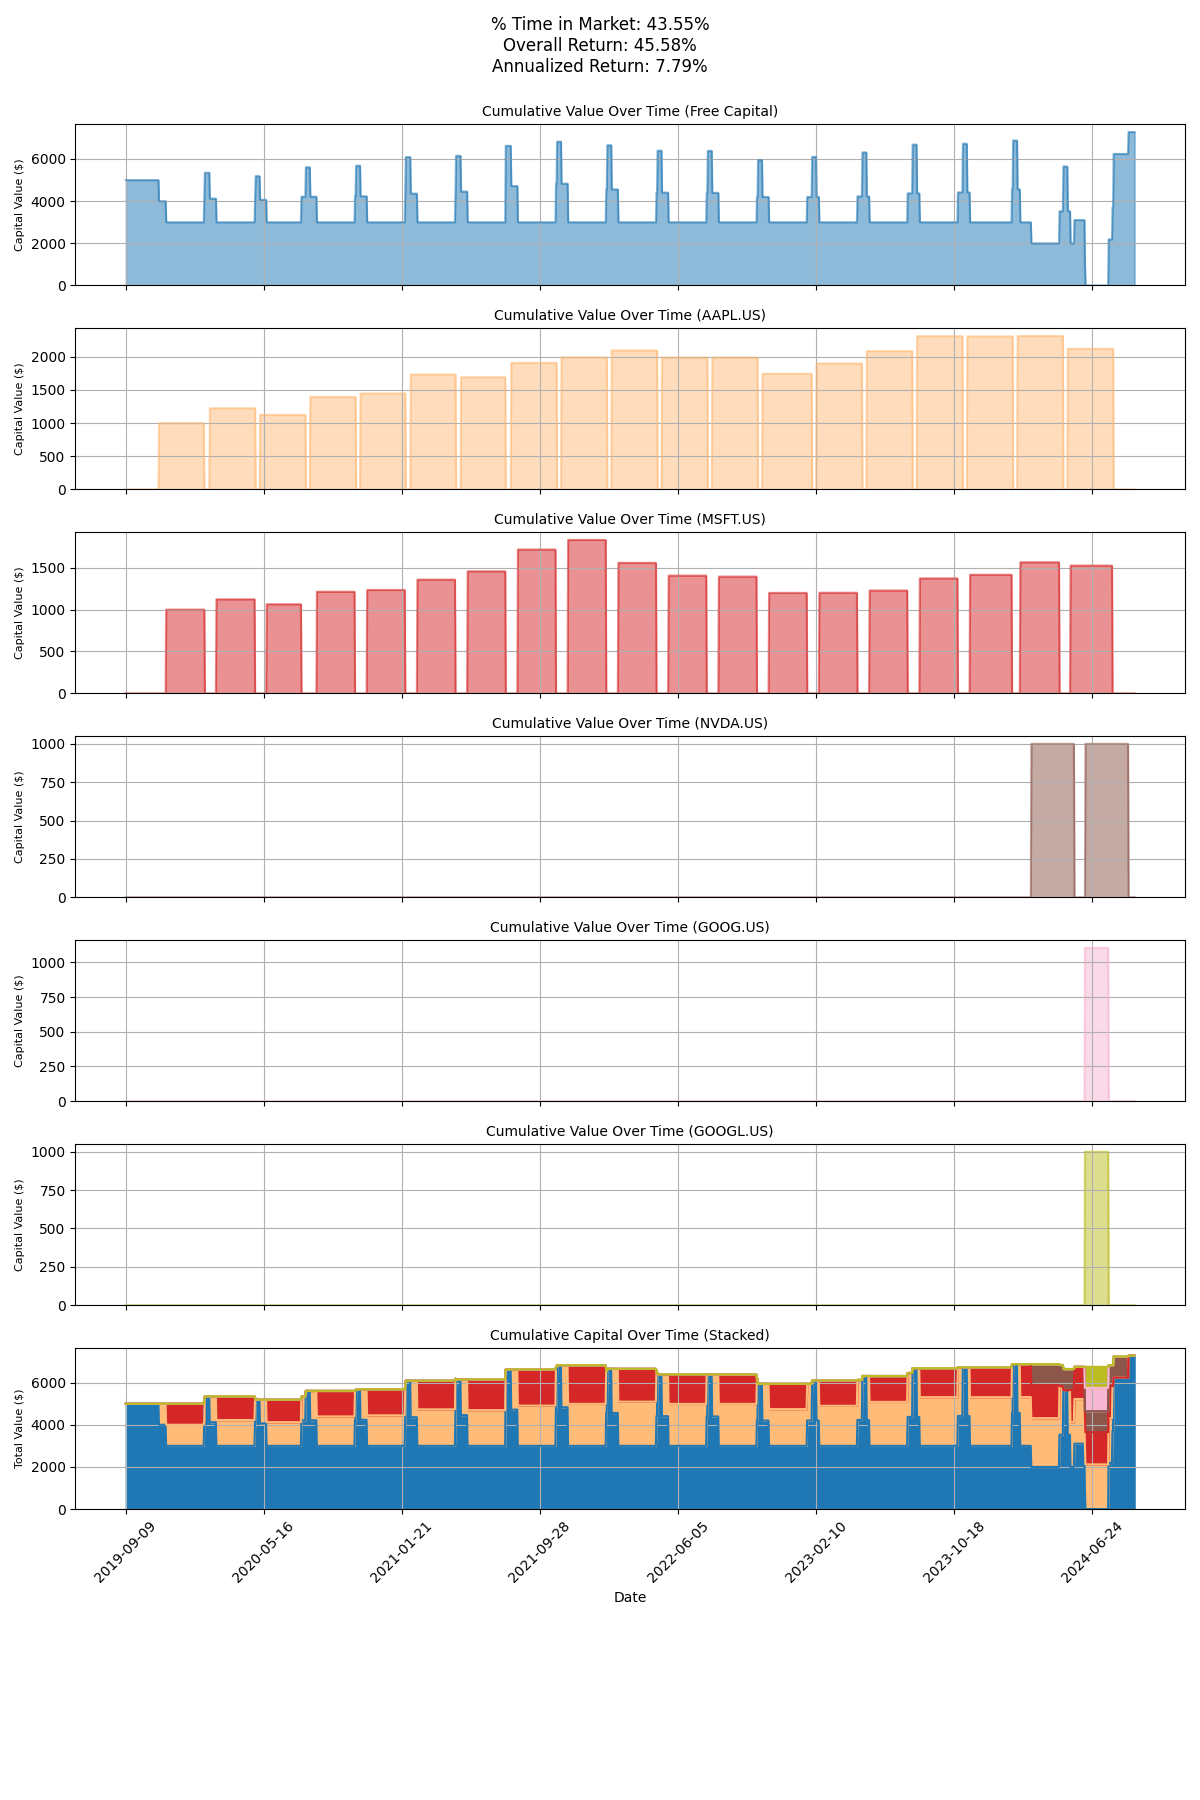

In [6]:
import chart_combined as cc
base64_image = cc.chart_combined(investment_results, start_date, end_date)
display(Image(data=base64.b64decode(base64_image), format='png'))